# Project MTI865 - Heart segmentation using UNet 

---

# Model evaluation 

## Importing libraries 

In [1]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
from progressBar import printProgressBar

import medicalDataLoader
import argparse
import utils

from UNet_Base import *
import random
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn import metrics as skmetrics
from scipy import stats 

import warnings
warnings.filterwarnings("ignore") 


## Loading data 

### Batch sizes

In [2]:
batch_size = 1
batch_size_val = 1
batch_size_unlabel = 1

### Mask and image transformation

In [3]:
# Define image and mask transformations
transform = v2.Compose([
    v2.ToTensor()
])

mask_transform = v2.Compose([
    v2.ToTensor()
])

### Data loaders 

In [4]:
def collate_fn(batch):
    imgs = []
    masks = []
    img_paths = []

    for item in batch:
        img, mask, img_path = item[0], item[1], item[2]
        imgs.append(img)
        img_paths.append(img_path)
        
        # Si le masque est None, ajouter un tenseur de zéros correspondant à sa taille
        if mask is not None:
            masks.append(mask)
        else:
            masks.append(torch.zeros_like(img[0, :, :]))  # Même taille que le canal de l'image (assumant CxHxW)

    # Stack les images et les masques
    imgs_tensor = torch.stack(imgs)  # Tensor de forme (B, C, H, W)
    masks_tensor = torch.stack(masks)  # Tensor de forme (B, H, W)

    return imgs_tensor, masks_tensor, img_paths

In [5]:
# Define dataloaders
root_dir = './data/'
print(' Dataset: {} '.format(root_dir))

supervised_set = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=True,
                                                    equalize=False)


supervised_loader = DataLoader(
    supervised_set,
    batch_size=batch_size,
    worker_init_fn=np.random.seed(0),
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn)


val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

unsupervised_set = medicalDataLoader.MedicalImageDataset('train-unlabelled',
                                                            root_dir,
                                                            transform=transform,
                                                            mask_transform=mask_transform,
                                                            augment=False,
                                                            equalize=False)
# print(train_unlabelled_set.imgs)
# train_unlabelled_set = [(img) for img, mask in train_unlabelled_set]
unsupervised_loader = DataLoader(unsupervised_set,
                                    batch_size=batch_size_unlabel,
                                    worker_init_fn=np.random.seed(0),
                                    num_workers=0,
                                    shuffle=False,
                                    collate_fn=collate_fn)

test_set = medicalDataLoader.MedicalImageDataset('test',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=True,
                                                    equalize=False)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size_unlabel,
    worker_init_fn=np.random.seed(0),
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn)


# Let's print the first batch to understand the data

for loader in [supervised_loader, val_loader, unsupervised_loader, test_loader]:
    imgs, masks, img_paths = next(iter(loader))
    print('Images shape: ', imgs.shape)
    print('Masks shape: ', masks.shape)
    # print('Image paths: ', img_paths)



 Dataset: ./data/ 
Found 204 items in train
First item:  ('./data/train/Img/patient006_01_1.png', './data/train/GT/patient006_01_1.png')
Found 74 items in val
First item:  ('./data/val/Img/patient001_01_1.png', './data/val/GT/patient001_01_1.png')
Found 1004 items in train-unlabelled
First item:  ('./data/train/Img-Unlabeled/patient007_01_1.png', None)
Found 314 items in test
First item:  ('./data/test/Img/patient002_01_1.png', './data/test/GT/patient002_01_1.png')
Images shape:  torch.Size([1, 1, 256, 256])
Masks shape:  torch.Size([1, 1, 256, 256])
Images shape:  torch.Size([1, 1, 256, 256])
Masks shape:  torch.Size([1, 1, 256, 256])
Images shape:  torch.Size([1, 1, 256, 256])
Masks shape:  torch.Size([1, 256, 256])
Images shape:  torch.Size([1, 1, 256, 256])
Masks shape:  torch.Size([1, 1, 256, 256])


## Loading a model 

### Loading the parameters

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.mps.is_available():  # Apple M-series of chips
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

epoch_to_load = 96
model = UNet(4).to(device=device)
modelName = 'Test_Model'
model.load_state_dict(torch.load(f"./models/{modelName}/{epoch_to_load}_Epoch"))

<All keys matched successfully>

### Visual comparison 

Number of batches:  74
('./data/val/Img/patient001_01_1.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.15514414, variance=0.03422768114724002, skewness=1.4491004664002445, kurtosis=1.2789437455624517)


Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.789301, 6.599825), mean=-1.5960175, variance=13.337303494657496, skewness=0.6095866035610676, kurtosis=-0.7036208067029088)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(1.0401807e-08, 0.99983764), mean=0.25, variance=0.17389389152580842, skewness=1.1841715437371605, kurtosis=-0.5342776579106912)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)


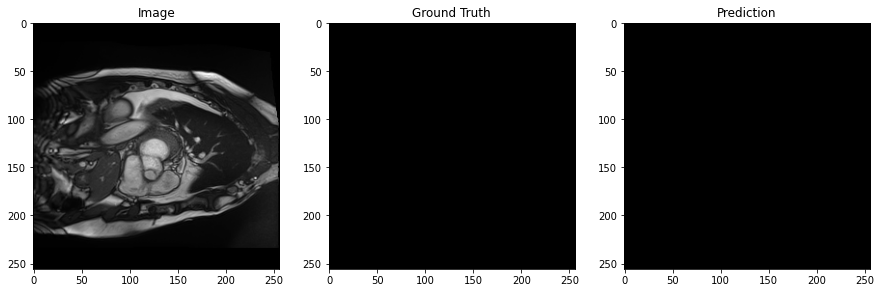

('./data/val/Img/patient001_01_10.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.13764428, variance=0.03832950442154002, skewness=1.5936364586805882, kurtosis=1.5966081598071957)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.924548, 6.8012114), mean=-1.600816, variance=12.864828547777357, skewness=0.648091227412688, kurtosis=-0.7222093460948398)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(7.3689286e-09, 0.99976605), mean=0.25, variance=0.1808435961002201, skewness=1.1667025450456168, kurtosis=-0.6138244860123163)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.030792236328125, variance=0.08001619389776217, skewness=9.470385465422172, kurtosis=90.

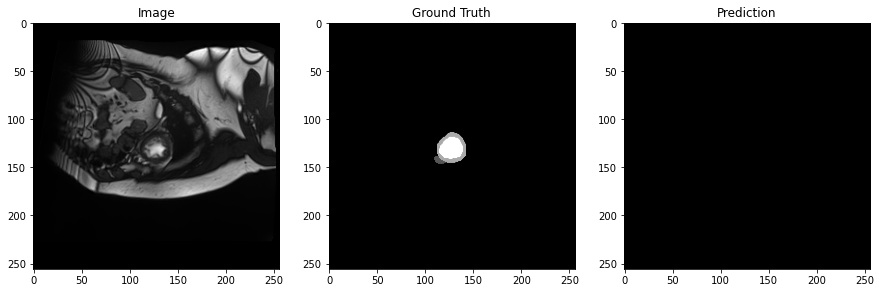

('./data/val/Img/patient001_01_2.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.13148701, variance=0.02603620903310254, skewness=1.565813713136184, kurtosis=1.7256562962226454)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.405533, 6.5145802), mean=-1.5970482, variance=13.357628279221645, skewness=0.608626098062517, kurtosis=-0.7106465281403302)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(1.6490773e-08, 0.9998115), mean=0.25, variance=0.17357791119732358, skewness=1.1868823032358382, kurtosis=-0.5240259444624527)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.109100341796875, variance=0.24594388580380475, skewness=4.8965590816617635, kurtosis=23.

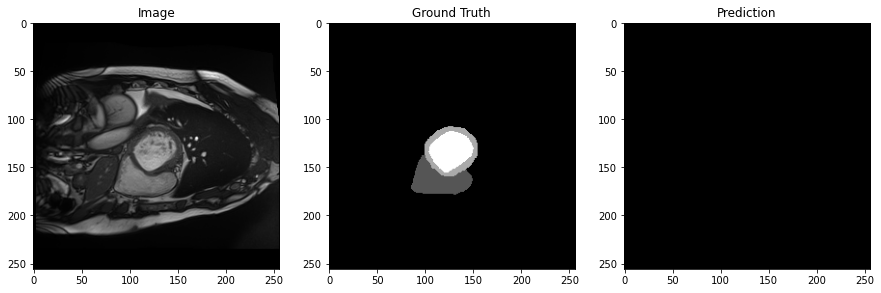

('./data/val/Img/patient001_01_3.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.10216645, variance=0.016476549163257227, skewness=1.6667701180945633, kurtosis=2.2372535512677114)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.996262, 6.7065086), mean=-1.6002233, variance=13.429663389829214, skewness=0.6041754954323777, kurtosis=-0.7185781337612678)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(7.540166e-09, 0.9997658), mean=0.25, variance=0.17347714916095414, skewness=1.1896129055718687, kurtosis=-0.513985957533384)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.121795654296875, variance=0.2854326251224894, skewness=4.608185525426909, kurtosis=20.4

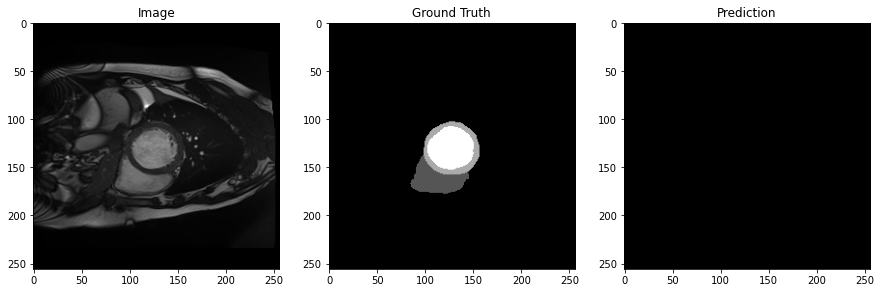

('./data/val/Img/patient001_01_4.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.11328299, variance=0.020676416123660068, skewness=1.7272963302939726, kurtosis=2.5369506879297923)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.80439, 6.7303996), mean=-1.6008176, variance=13.346561800238801, skewness=0.6100352521342931, kurtosis=-0.7231319832821703)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(9.21393e-09, 0.9997423), mean=0.25, variance=0.1744812081335378, skewness=1.1867720357177411, kurtosis=-0.5266465018165194)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.12408447265625, variance=0.2977484560671302, skewness=4.548054328359171, kurtosis=19.7338

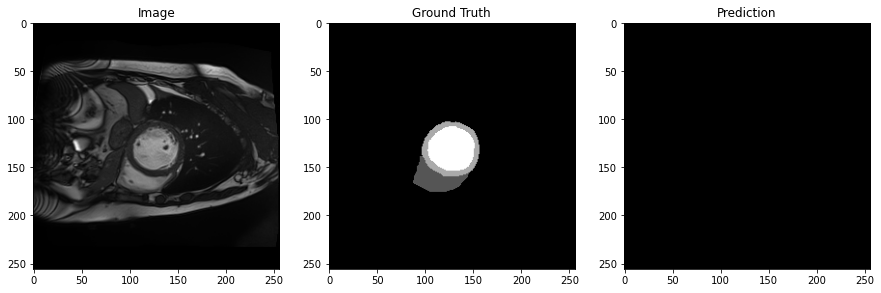

('./data/val/Img/patient001_01_5.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.1417063, variance=0.03202926811532006, skewness=1.70436445898642, kurtosis=2.372016822493137)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.538915, 6.491514), mean=-1.5935776, variance=13.14108139450605, skewness=0.6137968634141332, kurtosis=-0.7231808505164765)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(1.476872e-08, 0.99971133), mean=0.25, variance=0.17557637315320263, skewness=1.1836885522442557, kurtosis=-0.540535984706902)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.1192626953125, variance=0.29400843478198674, skewness=4.647363118551384, kurtosis=20.51779797

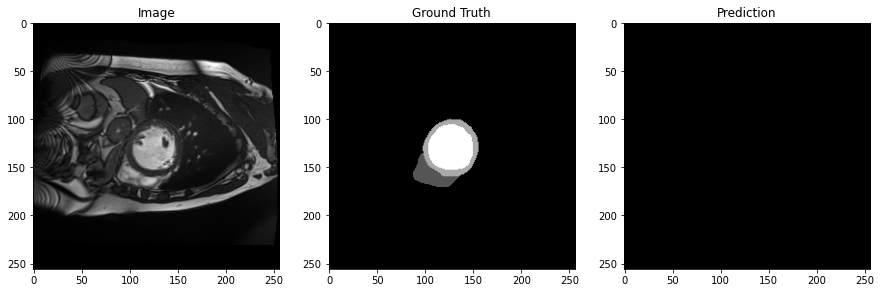

('./data/val/Img/patient001_01_6.png',)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.12894414, variance=0.027942454264658197, skewness=1.7151177997485036, kurtosis=2.3310966277798277)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.459994, 6.529407), mean=-1.6004469, variance=13.177480420991596, skewness=0.6235963404618403, kurtosis=-0.7294892188327036)
Probs : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(1.6743025e-08, 0.9997689), mean=0.25, variance=0.17653832128361238, skewness=1.1803560813904659, kurtosis=-0.5548635063262068)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape torch.Size([256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.109161376953125, variance=0.27284747858819475, skewness=4.868166045703469, kurtosis=22

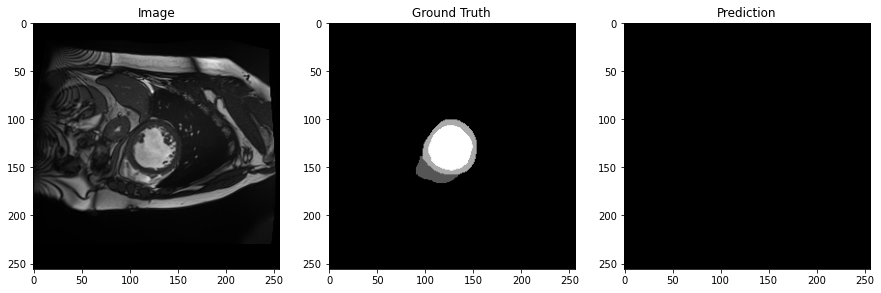

In [7]:
data_iterator = iter(val_loader)
num_batch = len(val_loader)
print('Number of batches: ', num_batch)

for i in range(num_batch):
    img, mask, path_img = next(data_iterator)
    print(path_img)
    img = utils.to_var(img)
    mask = utils.to_var(mask)

    print(f"Image : shape {img.shape}, stats : {stats.describe(img.flatten().cpu().numpy())}")
    img = img.to(device=device).detach()
    # print(f"Image : shape {img.shape}, stats : {stats.describe(img.flatten().cpu().numpy())}")
    mask = mask.to(device=device).detach()
    # print(f"Mask : shape {mask.shape}, stats : {stats.describe(mask.flatten().cpu().numpy())}")
    pred = model(img).detach()
    print(f"Pred : shape {pred.shape}, stats : {stats.describe(pred.flatten().cpu().numpy())}")

    probs = torch.softmax(pred, dim=1).detach()
    print(f"Probs : shape {probs.shape}, stats : {stats.describe(probs.flatten().cpu().numpy())}")
    y_pred = torch.argmax(probs, dim=1).detach()
    print(f"y_pred : shape {y_pred.shape}, stats : {stats.describe(y_pred.flatten().cpu().numpy())}") 

    y_true = utils.getTargetSegmentation(mask)
    print(f"y_true : shape {y_true.shape}, stats : {stats.describe(y_true.flatten().cpu().numpy())}")
    print("="*20)

    # Convert predictions and true values to numpy arrays 
    y_pred = y_pred.cpu().numpy()[0]
    y_true = y_true.cpu().numpy()

    # print(f"y_pred : shape {y_pred.shape}")
    # print(f"y_true : shape {y_true.shape}")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5)) 
    ax[0].imshow(img[0, 0, :, :], cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(y_true, cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[2].imshow(y_pred, cmap='gray')
    ax[2].set_title('Prediction')
    plt.show()
    if i> 5:
        break

### Building the confusion matrix for one image 

In [8]:
data_iterator = iter(val_loader)
num_batch = len(val_loader)
print('Number of batches: ', num_batch)

for i in range(num_batch):
    img, mask, _ = next(data_iterator)
    print(f"Image : shape {img.shape}, stats : {stats.describe(img.flatten().cpu().numpy())}")
    img = img.to(device=device).detach()
    # print(f"Image : shape {img.shape}, stats : {stats.describe(img.flatten().cpu().numpy())}")
    mask = mask.to(device=device).detach()
    # print(f"Mask : shape {mask.shape}, stats : {stats.describe(mask.flatten().cpu().numpy())}")
    pred = model(img).detach()
    print(f"Pred : shape {pred.shape}, stats : {stats.describe(pred.flatten().cpu().numpy())}")

    probs = torch.softmax(pred, dim=1).detach()
    # print(f"Probs : shape {probs.shape}, stats : {stats.describe(probs.flatten().cpu().numpy())}")
    y_pred = torch.argmax(probs, dim=1).detach()
    print(f"y_pred : shape {y_pred.shape}, stats : {stats.describe(y_pred.flatten().cpu().numpy())}") 

    y_true = utils.getTargetSegmentation(mask)
    # print(f"y_true : shape {y_true.shape}, stats : {stats.describe(y_true.flatten().cpu().numpy())}")

    # Convert predictions and true values to numpy arrays 
    y_pred = y_pred.cpu().numpy().flatten()
    y_true = y_true.cpu().numpy().flatten()

    print(f"y_pred : shape {y_pred.shape}, stats : {stats.describe(y_pred)}")
    print(f"y_true : shape {y_true.shape}, stats : {stats.describe(y_true)}")
    try : 
        confusionMatrix += skmetrics.confusion_matrix(y_true, y_pred)
    except :
        confusionMatrix = skmetrics.confusion_matrix(y_true, y_pred)

print(confusionMatrix)

normalizedConfusionMatrix = confusionMatrix / confusionMatrix.sum(axis=1)[:, np.newaxis]
print(normalizedConfusionMatrix)

Number of batches:  74
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.15514414, variance=0.03422768114724002, skewness=1.4491004664002445, kurtosis=1.2789437455624517)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.662303, 6.5171776), mean=-1.5971626, variance=13.286628862872554, skewness=0.618316589869501, kurtosis=-0.7061930794901063)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.13764428, variance=0.03832950442154002, skewness=1.59363

y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.121795654296875, variance=0.2854326251224894, skewness=4.608185525426909, kurtosis=20.478280797104407)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.11328299, variance=0.020676416123660068, skewness=1.7272963302939726, kurtosis=2.5369506879297923)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-12.072899, 6.7761173), mean=-1.6004684, variance=13.388847880736849, skewness=0.6063591639895589, kurtosis=-0.717748047599799)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.12088916, variance=0.02760410519843881, skewness=1.7006410079669585, kurtosis=2.2057989456714537)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.455359, 6.547968), mean=-1.6057652, variance=13.21807658415445, skewness=0.626425853279852, kurtosis=-0.7238803109979459)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.075592041015625, variance=0.19369065428867924, skewness=5.936386963862172, kurtosis=34.39201786649733)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.10958134, variance=0.02

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.06675003, variance=0.006672877658556735, skewness=1.6663213646989818, kurtosis=2.6986133153060354)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.974178, 6.828813), mean=-1.5949945, variance=13.349438092949267, skewness=0.6035495448859326, kurtosis=-0.6906753451233558)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0635833740234375, variance=0.16409625513762624, skewness=6.433166582961947, kurtosis=40.61230492958484)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.1299191, variance=0

Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-12.0502825, 6.8168445), mean=-1.6027492, variance=13.142301148609727, skewness=0.6284738316595613, kurtosis=-0.7371779782112142)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.097930908203125, variance=0.24438055132604478, skewness=5.108039728998523, kurtosis=25.080709383711984)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.12718901, variance=0.028503474780293928, skewness=1.6746482085107492, kurtosis=2.1935020813084103)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.556022, 6.5075855), mean=-1.610

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.12038928, variance=0.026938305569066148, skewness=1.3575955417535752, kurtosis=0.588207711866501)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.7053385, 6.729601), mean=-1.5949125, variance=12.991998641962592, skewness=0.6362408593457718, kurtosis=-0.7385778349568324)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.096038818359375, variance=0.22384270507737994, skewness=5.2630139319646805, kurtosis=27.38490382572518)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.10877482, variance=

y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.103607177734375, variance=0.2511102046720622, skewness=5.061101931115787, kurtosis=24.86800756575536)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.12159059, variance=0.026524875856531814, skewness=1.2766992591541717, kurtosis=0.2581702515466513)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.922115, 6.726773), mean=-1.5889517, variance=12.942375916961353, skewness=0.6284565720197062, kurtosis=-0.7280760112608604)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=n

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.16767383, variance=0.05044166598120279, skewness=1.3678819460591747, kurtosis=0.7294419524496072)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.719851, 6.660552), mean=-1.5980153, variance=12.906680704806154, skewness=0.639072289149421, kurtosis=-0.7343565937407903)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0807037353515625, variance=0.21069898441635135, skewness=5.742897671241582, kurtosis=31.89417356378126)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.15933336, variance=0.

Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.655436, 6.629683), mean=-1.6140482, variance=12.912774706934764, skewness=0.6664815407686029, kurtosis=-0.7372824956573831)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0204925537109375, variance=0.050316296640973694, skewness=11.307490168118903, kurtosis=130.75034221637694)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.11993936, variance=0.02602693850673781, skewness=1.3558103089842384, kurtosis=0.6345839112055915)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.514099, 6.5711455), mean=-1.596

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.16849415, variance=0.05016860548633364, skewness=1.3478138685556091, kurtosis=0.5749836467572038)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.643397, 6.5718412), mean=-1.5957611, variance=12.965179310528985, skewness=0.6347823488338724, kurtosis=-0.7350767846392752)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0934906005859375, variance=0.24564252827054187, skewness=5.30525324676935, kurtosis=26.86202493228797)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.16741095, variance=0

y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.04132080078125, variance=0.1035492984128233, skewness=8.081808768620064, kurtosis=65.80367502955325)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.21421033, variance=0.037881926314421686, skewness=0.6822620291783827, kurtosis=-0.5832860913319093)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.276262, 6.451438), mean=-1.5929734, variance=13.187696219239117, skewness=0.6260912684082486, kurtosis=-0.7288178279065116)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.119598388671875, variance=0.2473271966062385

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.25869477, variance=0.06165749039158465, skewness=0.6086417881362145, kurtosis=-0.9362907736839388)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-10.988072, 6.275293), mean=-1.6044446, variance=13.18807864409883, skewness=0.6397093369198152, kurtosis=-0.7359223451924559)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.078704833984375, variance=0.1949498812284824, skewness=5.899586384959299, kurtosis=34.32344840134718)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.27394927, variance=0.0

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.21817818, variance=0.038786049439230946, skewness=0.6612688671703613, kurtosis=-0.5961730447985478)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.305053, 6.4870653), mean=-1.5928541, variance=13.150568582796412, skewness=0.6285507979280057, kurtosis=-0.7161543309107028)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.07373046875, variance=0.15740801670862897, skewness=5.769775840404551, kurtosis=33.84628073307441)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.23616268, variance=0.0

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.24964678, variance=0.05511823581268597, skewness=0.668461010946557, kurtosis=-0.7129051202286116)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.2189455, 6.414881), mean=-1.6038538, variance=13.052200516511979, skewness=0.6457118418916012, kurtosis=-0.734301075138323)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0690155029296875, variance=0.15983585687417445, skewness=6.1805607043373145, kurtosis=38.49545343443389)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.26765886, variance=

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.23828122, variance=0.06435055129177157, skewness=0.7124365201849931, kurtosis=-0.9332969323183256)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.238701, 6.4218607), mean=-1.6127542, variance=13.076658541330495, skewness=0.6593306179677684, kurtosis=-0.7304813331675675)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.01092529296875, variance=0.027682574047980087, skewness=15.75146265667252, kurtosis=254.44400676828752)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.16807953, variance

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.14804976, variance=0.025721012999375334, skewness=1.339848962068947, kurtosis=1.0804976807459274)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-12.728392, 7.0946245), mean=-1.6040387, variance=13.292267960616915, skewness=0.6241356765865659, kurtosis=-0.7433264482505191)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.101287841796875, variance=0.22433281919817416, skewness=5.0782076905556695, kurtosis=25.76027247422651)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.18197878, variance=

Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-12.438958, 7.051922), mean=-1.6123586, variance=12.867969009281193, skewness=0.6639549678329827, kurtosis=-0.74785806187935)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0258636474609375, variance=0.06557047558638454, skewness=10.260737649223175, kurtosis=106.96376191600999)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.15291253, variance=0.037433573335097656, skewness=1.6394150372982355, kurtosis=2.158255754970357)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.664901, 6.6014557), mean=-1.608754

Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.15047501, variance=0.027496707165660526, skewness=1.5239016635714773, kurtosis=1.8069256192772096)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-12.353767, 6.991246), mean=-1.6045771, variance=13.356332230881618, skewness=0.6192192483499708, kurtosis=-0.7170652728472122)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0746917724609375, variance=0.14580581023580852, skewness=5.581945205287551, kurtosis=32.20092405013707)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.14040864, variance=

y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.048248291015625, variance=0.10710977193573806, skewness=7.227949071668078, kurtosis=53.58794446847974)
Image : shape torch.Size([1, 1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.11353408, variance=0.01793877771956302, skewness=1.6195550101044534, kurtosis=2.292744837215804)
Pred : shape torch.Size([1, 4, 256, 256]), stats : DescribeResult(nobs=262144, minmax=(-11.901122, 6.765382), mean=-1.6081719, variance=12.971026310067405, skewness=0.6473211133764571, kurtosis=-0.7317399728972309)
y_pred : shape torch.Size([1, 256, 256]), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_pred : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)
y_true : shape (65536,), stats : DescribeResult(nobs=65536, minmax=(0, 3), mean=0.0362091064453125, variance=0.0815301104815026